<a href="https://colab.research.google.com/github/mrdbourke/pytorch-deep-learning/blob/main/extras/exercises/04_pytorch_custom_datasets_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 04. PyTorch Custom Datasets Exercises Template

Welcome to the 04. PyTorch Custom Datasets exercise template.

The best way to practice PyTorch code is to write more PyTorch code.

So read the original notebook and try to complete the exercises by writing code where it's required.

Feel free to reference the original resources whenever you need but should practice writing all of the code yourself.

## Resources

1. These exercises/solutions are based on [notebook 04 of the Learn PyTorch for Deep Learning course](https://www.learnpytorch.io/04_pytorch_custom_datasets/).
2. See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/vsFMF9wqWx0).
3. See [other solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

In [1]:
# Check for GPU
!nvidia-smi

Fri Aug  9 21:22:35 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.70                 Driver Version: 560.70         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1650      WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   41C    P8              1W /   50W |     376MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# Import torch
import torch
from torch import nn

# Exercises require PyTorch > 1.10.0
print(torch.__version__)

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

2.4.0


'cuda'

## 1. Our models are underperforming (not fitting the data well). What are 3 methods for preventing underfitting? Write them down and explain each with a sentence.

1. Regularization - penalizes models for complex or large weights, which can reduce variance and prevent overfitting
2. Data augmentation - modify existing data by adding noise or transformations, which can add the data variability
3. Train with more data - by collecting more data or enhancing the data which equips your model with richer foundation

## 2. Recreate the data loading functions we built in [sections 1, 2, 3 and 4 of notebook 04](https://www.learnpytorch.io/04_pytorch_custom_datasets/). You should have train and test `DataLoader`'s ready to use.

In [3]:
# 1. Get data
from pathlib import Path 
import requests  
import zipfile

DIR_PATH = Path("data")
IMAGE_PATH = DIR_PATH / "pizza_steak_sushi.zip"

if IMAGE_PATH.is_file():
    print("the files already exist!")
else: 
    print("downloading...")
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    with open(DIR_PATH / "pizza_steak_sushi.zip", "wb") as f: 
        f.write(request.content)

the files already exist!


In [4]:
IMAGE_PATH

WindowsPath('data/pizza_steak_sushi.zip')

In [5]:
IMAGE_DATASET_PATH = DIR_PATH / "pizza_steak_sushi"

if IMAGE_DATASET_PATH.is_dir():
    print("already exists")
else: 
    print("unzipping...")
    with zipfile.ZipFile(IMAGE_PATH, "r") as zip_ref: 
        zip_ref.extractall(IMAGE_DATASET_PATH)

already exists


In [6]:
# 2. Become one with the data
import os
def walk_through_dir(dir_path):
  """Walks through dir_path returning file counts of its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [7]:
walk_through_dir(dir_path=IMAGE_DATASET_PATH)

There are 2 directories and 0 images in 'data\pizza_steak_sushi'.
There are 3 directories and 0 images in 'data\pizza_steak_sushi\test'.
There are 0 directories and 25 images in 'data\pizza_steak_sushi\test\pizza'.
There are 0 directories and 19 images in 'data\pizza_steak_sushi\test\steak'.
There are 0 directories and 31 images in 'data\pizza_steak_sushi\test\sushi'.
There are 3 directories and 0 images in 'data\pizza_steak_sushi\train'.
There are 0 directories and 78 images in 'data\pizza_steak_sushi\train\pizza'.
There are 0 directories and 75 images in 'data\pizza_steak_sushi\train\steak'.
There are 0 directories and 72 images in 'data\pizza_steak_sushi\train\sushi'.


In [8]:
IMAGE_DATASET_PATH

WindowsPath('data/pizza_steak_sushi')

In [9]:
# Setup train and testing paths
TRAIN_PATHS = list(IMAGE_DATASET_PATH.glob("train/*/*.jpg"))
TEST_PATHS = list(IMAGE_DATASET_PATH.glob("test/*/*.jpg"))

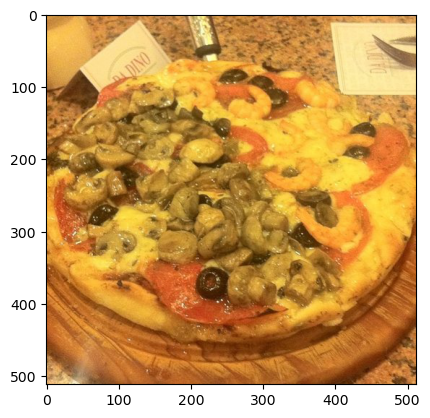

In [10]:
# Do the image visualization with matplotlib
import matplotlib.pyplot as plt 
from PIL import Image

plt.imshow(Image.open(TRAIN_PATHS[10]))

We've got some images in our folders.

Now we need to make them compatible with PyTorch by:
1. Transform the data into tensors.
2. Turn the tensor data into a `torch.utils.data.Dataset` and later a `torch.utils.data.DataLoader`.

In [11]:
# 3.1 Transforming data with torchvision.transforms
from torchvision import transforms

In [12]:
# Write transform for turning images into tensors
transform_data = transforms.Compose([ 
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [13]:
# Write a function to plot transformed images
def plot_transformed(image_path, transform_func, n: int): 
    plt.figure(figsize=(10, 15))

    fig, ax = plt.subplots(1, 2)
    with Image.open(image_path) as img: 
        # plot original image 
        ax[0].imshow(img)
        ax[0].set_title(f"original: {img.size}")
            
        # plot transformed image 
        transformed_img = transform_func(img).permute(1, 2, 0)
        ax[1].imshow(transformed_img)
        ax[1].set_title(f"tranformed: {transformed_img.shape}")

        plt.suptitle(image_path.parent.stem)
            

<Figure size 1000x1500 with 0 Axes>

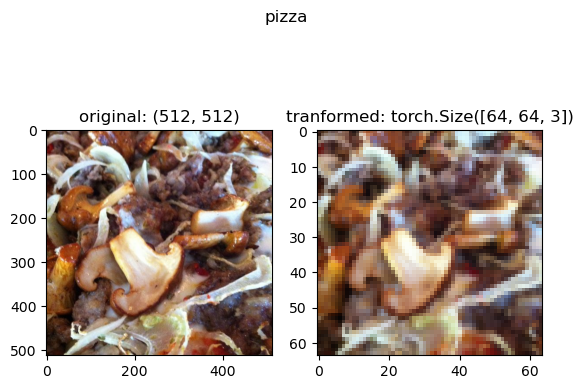

In [14]:
plot_transformed(image_path=TRAIN_PATHS[20], transform_func=transform_data, n=10)

### Load image data using `ImageFolder`

In [15]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets

train_path = IMAGE_DATASET_PATH / "train"
test_path = IMAGE_DATASET_PATH / "test"

train_data = datasets.ImageFolder(root=train_path, transform=transform_data)
test_data = datasets.ImageFolder(root=test_path, transform=transform_data)

In [16]:
len(train_data), len(test_data)

(225, 75)

In [17]:
# Get class names as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [18]:
# Can also get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [19]:
# Check the lengths of each dataset
len(train_data), len(test_data)

(225, 75)

In [20]:
# Turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=False)

In [21]:
# How many batches of images are in our data loaders?
a, b = next(iter(train_dataloader))
a, b, len(train_dataloader)

(tensor([[[[0.9882, 0.9961, 0.9961,  ..., 0.2627, 0.2510, 0.2902],
           [0.9882, 0.9922, 0.9961,  ..., 0.3020, 0.3137, 0.3216],
           [0.9922, 0.9961, 0.9961,  ..., 0.2157, 0.2784, 0.3725],
           ...,
           [0.9333, 0.9255, 0.9020,  ..., 0.9176, 0.9373, 0.9412],
           [0.9412, 0.9412, 0.9373,  ..., 0.9412, 0.9412, 0.9412],
           [0.9373, 0.9412, 0.9412,  ..., 0.9569, 0.9529, 0.9490]],
 
          [[0.7843, 0.7922, 0.8039,  ..., 0.1529, 0.1412, 0.1765],
           [0.8078, 0.8078, 0.8118,  ..., 0.1882, 0.1922, 0.2000],
           [0.8118, 0.8157, 0.8157,  ..., 0.1176, 0.1725, 0.2510],
           ...,
           [0.7137, 0.7059, 0.6824,  ..., 0.7098, 0.7333, 0.7373],
           [0.7216, 0.7216, 0.7176,  ..., 0.7373, 0.7373, 0.7373],
           [0.7137, 0.7216, 0.7176,  ..., 0.7529, 0.7569, 0.7529]],
 
          [[0.6627, 0.6784, 0.6784,  ..., 0.1020, 0.1020, 0.1373],
           [0.6784, 0.6863, 0.6902,  ..., 0.1412, 0.1294, 0.1294],
           [0.6902, 0.68

In [22]:
class_name = train_data.classes
class_name

['pizza', 'steak', 'sushi']

## 3. Recreate `model_0` we built in section 7 of notebook 04.

In [23]:
# set device agnostic-code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [24]:
from torch import nn

In [25]:
class TinyVGG(nn.Module):
    def __init__(self, input_shape, output_shape, hidden_units=10): 
        super().__init__()

        # 32
        self.conv_layer_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2)
        )

        # 16
        self.conv_layer_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2)
        )

        # 8
        self.conv_layer_3 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2)
        )

        self.classifier = nn.Sequential( 
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*8*8, out_features=output_shape)
        )

    def forward(self, x):
        return self.classifier(self.conv_layer_3(self.conv_layer_2(self.conv_layer_1(x))))
    
model_0 = TinyVGG(input_shape=3, output_shape=len(class_name), hidden_units=64).to(device)
model_0

TinyVGG(
  (conv_layer_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer_2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer_3): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_fea

In [26]:
from torchinfo import summary

summary(model=model_0, input_size=(32, 3, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [32, 3]                   --
├─Sequential: 1-1                        [32, 64, 32, 32]          --
│    └─Conv2d: 2-1                       [32, 64, 64, 64]          1,792
│    └─ReLU: 2-2                         [32, 64, 64, 64]          --
│    └─Conv2d: 2-3                       [32, 64, 64, 64]          36,928
│    └─ReLU: 2-4                         [32, 64, 64, 64]          --
│    └─MaxPool2d: 2-5                    [32, 64, 32, 32]          --
├─Sequential: 1-2                        [32, 64, 16, 16]          --
│    └─Conv2d: 2-6                       [32, 64, 32, 32]          36,928
│    └─ReLU: 2-7                         [32, 64, 32, 32]          --
│    └─Conv2d: 2-8                       [32, 64, 32, 32]          36,928
│    └─ReLU: 2-9                         [32, 64, 32, 32]          --
│    └─MaxPool2d: 2-10                   [32, 64, 16, 16]          --


## 4. Create training and testing functions for `model_0`.

In [27]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
  
  # Put the model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader and data batches
  for batch, (X, y) in enumerate(dataloader):
    # Send data to target device
    X, y = X.to(device), y.to(device)
    # 1. Forward pass
    logits = model(X)
    # 2. Calculate and accumulate loss
    loss = loss_fn(logits, y)
    pred = torch.softmax(logits, dim=1).argmax(dim=1)
    # 3. Optimizer zero grad 
    optimizer.zero_grad()
    # 4. Loss backward 
    loss.backward()
    # 5. Optimizer step
    optimizer.step()

    # Calculate and accumualte accuracy metric across all batches
    train_loss += loss
    train_acc += (pred==y).sum().item() / len(logits)
  # Adjust metrics to get average loss and average accuracy per batch
  train_loss /= len(dataloader)
  train_acc /= len(dataloader)

  return train_loss, train_acc

In [28]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
  
  # Put model in eval mode
  model.eval()

  # Setup the test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference context manager
  with torch.inference_mode():
  
    # Loop through DataLoader batches
    for X, y in dataloader:
      # Send data to target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      test_logits = model(X)

      # 2. Calculuate and accumulate loss
      test_loss += loss_fn(test_logits, y)
      pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
      # Calculate and accumulate accuracy
      test_acc += (pred==y).sum().item() / len(test_logits)
    
    # Adjust metrics to get average loss and accuracy per batch
    test_loss /= len(dataloader)
    test_acc /= len(dataloader)

  return test_loss, test_acc

In [29]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
  
  # Create results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  # Loop through the training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    # Train step
    train_loss, train_acc = train_step(model=model, 
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer)
    # Test step
    test_loss, test_acc = test_step(model=model, 
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn)
    
    # Print out what's happening
    print(f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
    )

    # Update the results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  # Return the results dictionary
  return results

c:\Users\bolth\anaconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 5. Try training the model you made in exercise 3 for 5, 20 and 50 epochs, what happens to the results?
* Use `torch.optim.Adam()` with a learning rate of 0.001 as the optimizer. 

In [30]:
# Train for 5 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

model_0_adam_result = train(model=model_0, train_dataloader=train_dataloader, test_dataloader=test_dataloader, optimizer=optimizer, loss_fn=loss_fn, epochs=5)

 20%|██        | 1/5 [00:01<00:04,  1.16s/it]

Epoch: 1 | train_loss: 1.1038 | train_acc: 0.2812 | test_loss: 1.1010 | test_acc: 0.2604


 40%|████      | 2/5 [00:02<00:03,  1.10s/it]

Epoch: 2 | train_loss: 1.0922 | train_acc: 0.4258 | test_loss: 1.1116 | test_acc: 0.2604


 60%|██████    | 3/5 [00:03<00:02,  1.07s/it]

Epoch: 3 | train_loss: 1.0861 | train_acc: 0.4258 | test_loss: 1.1282 | test_acc: 0.2604


 80%|████████  | 4/5 [00:04<00:01,  1.11s/it]

Epoch: 4 | train_loss: 1.0940 | train_acc: 0.3359 | test_loss: 1.1297 | test_acc: 0.2604


100%|██████████| 5/5 [00:05<00:00,  1.12s/it]

Epoch: 5 | train_loss: 0.9654 | train_acc: 0.5703 | test_loss: 1.0779 | test_acc: 0.3930


In [31]:
# Train for 20 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), 
                             lr=0.001)

model_0_adam_result_1 = train(model=model_0, train_dataloader=train_dataloader, test_dataloader=test_dataloader, optimizer=optimizer, loss_fn=loss_fn, epochs=20)

  5%|▌         | 1/20 [00:01<00:22,  1.18s/it]

Epoch: 1 | train_loss: 0.9213 | train_acc: 0.6172 | test_loss: 1.0079 | test_acc: 0.3532


 10%|█         | 2/20 [00:02<00:21,  1.20s/it]

Epoch: 2 | train_loss: 0.8811 | train_acc: 0.6172 | test_loss: 1.0600 | test_acc: 0.3627


 15%|█▌        | 3/20 [00:03<00:20,  1.19s/it]

Epoch: 3 | train_loss: 0.8328 | train_acc: 0.6094 | test_loss: 0.9755 | test_acc: 0.4848


 20%|██        | 4/20 [00:04<00:19,  1.20s/it]

Epoch: 4 | train_loss: 0.8389 | train_acc: 0.6562 | test_loss: 1.0283 | test_acc: 0.5047


 25%|██▌       | 5/20 [00:05<00:18,  1.20s/it]

Epoch: 5 | train_loss: 0.7410 | train_acc: 0.6719 | test_loss: 1.0782 | test_acc: 0.4536


 30%|███       | 6/20 [00:07<00:16,  1.19s/it]

Epoch: 6 | train_loss: 0.9351 | train_acc: 0.5391 | test_loss: 1.0663 | test_acc: 0.4744


 35%|███▌      | 7/20 [00:08<00:15,  1.20s/it]

Epoch: 7 | train_loss: 0.7605 | train_acc: 0.6758 | test_loss: 1.0200 | test_acc: 0.3939


 40%|████      | 8/20 [00:09<00:14,  1.22s/it]

Epoch: 8 | train_loss: 0.8009 | train_acc: 0.6797 | test_loss: 1.0411 | test_acc: 0.4545


 45%|████▌     | 9/20 [00:10<00:13,  1.20s/it]

Epoch: 9 | train_loss: 0.8349 | train_acc: 0.5742 | test_loss: 1.1080 | test_acc: 0.5256


 50%|█████     | 10/20 [00:11<00:11,  1.19s/it]

Epoch: 10 | train_loss: 0.7673 | train_acc: 0.6836 | test_loss: 0.9940 | test_acc: 0.4129


 55%|█████▌    | 11/20 [00:13<00:10,  1.18s/it]

Epoch: 11 | train_loss: 0.7078 | train_acc: 0.6992 | test_loss: 1.0936 | test_acc: 0.4034


 60%|██████    | 12/20 [00:14<00:09,  1.17s/it]

Epoch: 12 | train_loss: 0.6276 | train_acc: 0.7305 | test_loss: 1.0853 | test_acc: 0.4640


 65%|██████▌   | 13/20 [00:15<00:08,  1.17s/it]

Epoch: 13 | train_loss: 0.6135 | train_acc: 0.7500 | test_loss: 1.3704 | test_acc: 0.3438


 70%|███████   | 14/20 [00:16<00:07,  1.17s/it]

Epoch: 14 | train_loss: 0.7173 | train_acc: 0.7109 | test_loss: 1.4703 | test_acc: 0.3220


 75%|███████▌  | 15/20 [00:17<00:05,  1.19s/it]

Epoch: 15 | train_loss: 0.8330 | train_acc: 0.6016 | test_loss: 1.1420 | test_acc: 0.4659


 80%|████████  | 16/20 [00:19<00:04,  1.20s/it]

Epoch: 16 | train_loss: 0.6277 | train_acc: 0.7422 | test_loss: 1.1461 | test_acc: 0.4138


 85%|████████▌ | 17/20 [00:20<00:03,  1.21s/it]

Epoch: 17 | train_loss: 0.6083 | train_acc: 0.7617 | test_loss: 1.3287 | test_acc: 0.4451


 90%|█████████ | 18/20 [00:21<00:02,  1.24s/it]

Epoch: 18 | train_loss: 0.5599 | train_acc: 0.7500 | test_loss: 1.1380 | test_acc: 0.5350


 95%|█████████▌| 19/20 [00:22<00:01,  1.25s/it]

Epoch: 19 | train_loss: 0.4767 | train_acc: 0.8359 | test_loss: 1.2033 | test_acc: 0.5360


100%|██████████| 20/20 [00:24<00:00,  1.21s/it]

Epoch: 20 | train_loss: 0.5063 | train_acc: 0.7109 | test_loss: 1.3856 | test_acc: 0.5862


In [32]:
# Train for 50 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), 
                             lr=0.001)

model_0_adam_result_2 = train(model=model_0, train_dataloader=train_dataloader, test_dataloader=test_dataloader, optimizer=optimizer, loss_fn=loss_fn, epochs=50)


  2%|▏         | 1/50 [00:01<01:02,  1.28s/it]

Epoch: 1 | train_loss: 0.4314 | train_acc: 0.8086 | test_loss: 1.2664 | test_acc: 0.4848


  4%|▍         | 2/50 [00:02<01:00,  1.25s/it]

Epoch: 2 | train_loss: 0.4238 | train_acc: 0.7617 | test_loss: 2.4270 | test_acc: 0.4650


  6%|▌         | 3/50 [00:03<00:57,  1.22s/it]

Epoch: 3 | train_loss: 0.5377 | train_acc: 0.8008 | test_loss: 1.5911 | test_acc: 0.5152


  8%|▊         | 4/50 [00:04<00:55,  1.21s/it]

Epoch: 4 | train_loss: 0.3515 | train_acc: 0.8828 | test_loss: 1.2824 | test_acc: 0.5559


 10%|█         | 5/50 [00:06<00:55,  1.23s/it]

Epoch: 5 | train_loss: 0.2875 | train_acc: 0.8867 | test_loss: 1.5647 | test_acc: 0.4848


 12%|█▏        | 6/50 [00:07<00:55,  1.25s/it]

Epoch: 6 | train_loss: 0.2284 | train_acc: 0.9023 | test_loss: 1.7612 | test_acc: 0.5966


 14%|█▍        | 7/50 [00:08<00:53,  1.25s/it]

Epoch: 7 | train_loss: 0.1517 | train_acc: 0.9492 | test_loss: 2.0291 | test_acc: 0.5152


 16%|█▌        | 8/50 [00:09<00:52,  1.25s/it]

Epoch: 8 | train_loss: 0.1517 | train_acc: 0.9609 | test_loss: 2.2660 | test_acc: 0.5256


 18%|█▊        | 9/50 [00:11<00:51,  1.25s/it]

Epoch: 9 | train_loss: 0.0909 | train_acc: 0.9688 | test_loss: 2.7900 | test_acc: 0.5455


 20%|██        | 10/50 [00:12<00:49,  1.24s/it]

Epoch: 10 | train_loss: 0.0597 | train_acc: 0.9805 | test_loss: 3.0612 | test_acc: 0.5256


 22%|██▏       | 11/50 [00:13<00:48,  1.25s/it]

Epoch: 11 | train_loss: 0.0262 | train_acc: 1.0000 | test_loss: 3.1630 | test_acc: 0.5360


 24%|██▍       | 12/50 [00:14<00:47,  1.24s/it]

Epoch: 12 | train_loss: 0.0152 | train_acc: 1.0000 | test_loss: 3.7472 | test_acc: 0.5360


 26%|██▌       | 13/50 [00:16<00:46,  1.25s/it]

Epoch: 13 | train_loss: 0.0087 | train_acc: 1.0000 | test_loss: 4.0571 | test_acc: 0.5256


 28%|██▊       | 14/50 [00:17<00:44,  1.23s/it]

Epoch: 14 | train_loss: 0.0036 | train_acc: 1.0000 | test_loss: 4.1884 | test_acc: 0.5559


 30%|███       | 15/50 [00:18<00:43,  1.23s/it]

Epoch: 15 | train_loss: 0.0039 | train_acc: 1.0000 | test_loss: 4.4896 | test_acc: 0.5047


 32%|███▏      | 16/50 [00:19<00:42,  1.25s/it]

Epoch: 16 | train_loss: 0.0021 | train_acc: 1.0000 | test_loss: 4.9655 | test_acc: 0.4943


 34%|███▍      | 17/50 [00:21<00:40,  1.24s/it]

Epoch: 17 | train_loss: 0.0022 | train_acc: 1.0000 | test_loss: 4.7351 | test_acc: 0.5360


 36%|███▌      | 18/50 [00:22<00:39,  1.22s/it]

Epoch: 18 | train_loss: 0.0012 | train_acc: 1.0000 | test_loss: 4.8287 | test_acc: 0.5152


 38%|███▊      | 19/50 [00:23<00:36,  1.19s/it]

Epoch: 19 | train_loss: 0.0010 | train_acc: 1.0000 | test_loss: 4.9902 | test_acc: 0.5047


 40%|████      | 20/50 [00:24<00:35,  1.19s/it]

Epoch: 20 | train_loss: 0.0010 | train_acc: 1.0000 | test_loss: 5.0195 | test_acc: 0.5047


 42%|████▏     | 21/50 [00:25<00:35,  1.21s/it]

Epoch: 21 | train_loss: 0.0007 | train_acc: 1.0000 | test_loss: 5.1319 | test_acc: 0.5047


 44%|████▍     | 22/50 [00:26<00:33,  1.19s/it]

Epoch: 22 | train_loss: 0.0005 | train_acc: 1.0000 | test_loss: 5.2909 | test_acc: 0.5047


 46%|████▌     | 23/50 [00:28<00:31,  1.18s/it]

Epoch: 23 | train_loss: 0.0004 | train_acc: 1.0000 | test_loss: 5.3545 | test_acc: 0.4943


 48%|████▊     | 24/50 [00:29<00:30,  1.17s/it]

Epoch: 24 | train_loss: 0.0005 | train_acc: 1.0000 | test_loss: 5.4220 | test_acc: 0.5152


 50%|█████     | 25/50 [00:30<00:28,  1.15s/it]

Epoch: 25 | train_loss: 0.0004 | train_acc: 1.0000 | test_loss: 5.4919 | test_acc: 0.5047


 52%|█████▏    | 26/50 [00:31<00:27,  1.15s/it]

Epoch: 26 | train_loss: 0.0003 | train_acc: 1.0000 | test_loss: 5.7082 | test_acc: 0.5047


 54%|█████▍    | 27/50 [00:32<00:26,  1.16s/it]

Epoch: 27 | train_loss: 0.0002 | train_acc: 1.0000 | test_loss: 5.8484 | test_acc: 0.5047


 56%|█████▌    | 28/50 [00:33<00:25,  1.16s/it]

Epoch: 28 | train_loss: 0.0002 | train_acc: 1.0000 | test_loss: 5.9224 | test_acc: 0.5047


 58%|█████▊    | 29/50 [00:35<00:24,  1.16s/it]

Epoch: 29 | train_loss: 0.0002 | train_acc: 1.0000 | test_loss: 6.0060 | test_acc: 0.5047


 60%|██████    | 30/50 [00:36<00:23,  1.18s/it]

Epoch: 30 | train_loss: 0.0001 | train_acc: 1.0000 | test_loss: 6.1083 | test_acc: 0.5047


 62%|██████▏   | 31/50 [00:37<00:22,  1.19s/it]

Epoch: 31 | train_loss: 0.0001 | train_acc: 1.0000 | test_loss: 6.2118 | test_acc: 0.5047


 64%|██████▍   | 32/50 [00:38<00:21,  1.18s/it]

Epoch: 32 | train_loss: 0.0001 | train_acc: 1.0000 | test_loss: 6.2643 | test_acc: 0.5047


 66%|██████▌   | 33/50 [00:39<00:20,  1.18s/it]

Epoch: 33 | train_loss: 0.0002 | train_acc: 1.0000 | test_loss: 6.4242 | test_acc: 0.5047


 68%|██████▊   | 34/50 [00:41<00:19,  1.19s/it]

Epoch: 34 | train_loss: 0.0001 | train_acc: 1.0000 | test_loss: 6.6908 | test_acc: 0.4943


 70%|███████   | 35/50 [00:42<00:17,  1.20s/it]

Epoch: 35 | train_loss: 0.0001 | train_acc: 1.0000 | test_loss: 6.5986 | test_acc: 0.5047


 72%|███████▏  | 36/50 [00:43<00:16,  1.19s/it]

Epoch: 36 | train_loss: 0.0002 | train_acc: 1.0000 | test_loss: 6.5188 | test_acc: 0.5256


 74%|███████▍  | 37/50 [00:44<00:15,  1.19s/it]

Epoch: 37 | train_loss: 0.0002 | train_acc: 1.0000 | test_loss: 6.5910 | test_acc: 0.5256


 76%|███████▌  | 38/50 [00:45<00:14,  1.19s/it]

Epoch: 38 | train_loss: 0.0001 | train_acc: 1.0000 | test_loss: 6.8827 | test_acc: 0.5152


 78%|███████▊  | 39/50 [00:47<00:13,  1.20s/it]

Epoch: 39 | train_loss: 0.0001 | train_acc: 1.0000 | test_loss: 6.8957 | test_acc: 0.5047


 80%|████████  | 40/50 [00:48<00:11,  1.18s/it]

Epoch: 40 | train_loss: 0.0000 | train_acc: 1.0000 | test_loss: 6.8689 | test_acc: 0.5047


 82%|████████▏ | 41/50 [00:49<00:10,  1.16s/it]

Epoch: 41 | train_loss: 0.0000 | train_acc: 1.0000 | test_loss: 6.9491 | test_acc: 0.5047


 84%|████████▍ | 42/50 [00:50<00:09,  1.15s/it]

Epoch: 42 | train_loss: 0.0000 | train_acc: 1.0000 | test_loss: 7.0595 | test_acc: 0.5047


 86%|████████▌ | 43/50 [00:51<00:08,  1.15s/it]

Epoch: 43 | train_loss: 0.0000 | train_acc: 1.0000 | test_loss: 7.1671 | test_acc: 0.5047


 88%|████████▊ | 44/50 [00:52<00:06,  1.15s/it]

Epoch: 44 | train_loss: 0.0000 | train_acc: 1.0000 | test_loss: 7.1976 | test_acc: 0.5152


 90%|█████████ | 45/50 [00:53<00:05,  1.14s/it]

Epoch: 45 | train_loss: 0.0000 | train_acc: 1.0000 | test_loss: 7.2985 | test_acc: 0.5047


 92%|█████████▏| 46/50 [00:54<00:04,  1.15s/it]

Epoch: 46 | train_loss: 0.0000 | train_acc: 1.0000 | test_loss: 7.3675 | test_acc: 0.5152


 94%|█████████▍| 47/50 [00:56<00:03,  1.14s/it]

Epoch: 47 | train_loss: 0.0000 | train_acc: 1.0000 | test_loss: 7.4011 | test_acc: 0.5256


 96%|█████████▌| 48/50 [00:57<00:02,  1.14s/it]

Epoch: 48 | train_loss: 0.0000 | train_acc: 1.0000 | test_loss: 7.4977 | test_acc: 0.5152


 98%|█████████▊| 49/50 [00:58<00:01,  1.14s/it]

Epoch: 49 | train_loss: 0.0000 | train_acc: 1.0000 | test_loss: 7.5428 | test_acc: 0.5152


100%|██████████| 50/50 [00:59<00:00,  1.19s/it]

Epoch: 50 | train_loss: 0.0000 | train_acc: 1.0000 | test_loss: 7.5135 | test_acc: 0.5152


It looks like our model is starting to overfit towards the end (performing far better on the training data than on the testing data).

In order to fix this, we'd have to introduce ways of preventing overfitting.

## 6. Double the number of hidden units in your model and train it for 20 epochs, what happens to the results?

In [33]:
# Double the number of hidden units and train for 20 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_1 = TinyVGG(input_shape=3, output_shape=len(class_names), hidden_units=128).to(device)
model_1

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), 
                             lr=0.001)

model_1_adam_result = train(model=model_1, train_dataloader=train_dataloader, test_dataloader=test_dataloader, optimizer=optimizer, loss_fn=loss_fn, epochs=20)

  5%|▌         | 1/20 [00:01<00:27,  1.45s/it]

Epoch: 1 | train_loss: 1.0978 | train_acc: 0.4023 | test_loss: 1.0957 | test_acc: 0.5417


 10%|█         | 2/20 [00:02<00:24,  1.36s/it]

Epoch: 2 | train_loss: 1.1000 | train_acc: 0.2812 | test_loss: 1.0957 | test_acc: 0.5417


 15%|█▌        | 3/20 [00:04<00:22,  1.32s/it]

Epoch: 3 | train_loss: 1.0986 | train_acc: 0.2812 | test_loss: 1.0957 | test_acc: 0.5417


 20%|██        | 4/20 [00:05<00:20,  1.30s/it]

Epoch: 4 | train_loss: 1.0978 | train_acc: 0.4023 | test_loss: 1.0957 | test_acc: 0.5417


 25%|██▌       | 5/20 [00:06<00:19,  1.30s/it]

Epoch: 5 | train_loss: 1.0979 | train_acc: 0.4023 | test_loss: 1.0957 | test_acc: 0.5417


 30%|███       | 6/20 [00:07<00:18,  1.29s/it]

Epoch: 6 | train_loss: 1.0978 | train_acc: 0.4023 | test_loss: 1.0957 | test_acc: 0.5417


 35%|███▌      | 7/20 [00:09<00:16,  1.29s/it]

Epoch: 7 | train_loss: 1.0978 | train_acc: 0.4023 | test_loss: 1.0957 | test_acc: 0.5417


 40%|████      | 8/20 [00:10<00:15,  1.29s/it]

Epoch: 8 | train_loss: 1.0986 | train_acc: 0.2812 | test_loss: 1.0957 | test_acc: 0.5417


 45%|████▌     | 9/20 [00:11<00:14,  1.28s/it]

Epoch: 9 | train_loss: 1.0979 | train_acc: 0.4023 | test_loss: 1.0957 | test_acc: 0.5417


 50%|█████     | 10/20 [00:12<00:12,  1.28s/it]

Epoch: 10 | train_loss: 1.0988 | train_acc: 0.2812 | test_loss: 1.0957 | test_acc: 0.5417


 55%|█████▌    | 11/20 [00:14<00:11,  1.28s/it]

Epoch: 11 | train_loss: 1.1000 | train_acc: 0.2812 | test_loss: 1.0957 | test_acc: 0.5417


 60%|██████    | 12/20 [00:15<00:10,  1.28s/it]

Epoch: 12 | train_loss: 1.0987 | train_acc: 0.2812 | test_loss: 1.0957 | test_acc: 0.5417


 65%|██████▌   | 13/20 [00:16<00:08,  1.27s/it]

Epoch: 13 | train_loss: 1.0986 | train_acc: 0.2812 | test_loss: 1.0957 | test_acc: 0.5417


 70%|███████   | 14/20 [00:18<00:07,  1.28s/it]

Epoch: 14 | train_loss: 1.0986 | train_acc: 0.2812 | test_loss: 1.0957 | test_acc: 0.5417


 75%|███████▌  | 15/20 [00:19<00:06,  1.27s/it]

Epoch: 15 | train_loss: 1.0978 | train_acc: 0.4023 | test_loss: 1.0957 | test_acc: 0.5417


 80%|████████  | 16/20 [00:20<00:05,  1.27s/it]

Epoch: 16 | train_loss: 1.0987 | train_acc: 0.2812 | test_loss: 1.0957 | test_acc: 0.5417


 85%|████████▌ | 17/20 [00:21<00:03,  1.28s/it]

Epoch: 17 | train_loss: 1.0987 | train_acc: 0.2812 | test_loss: 1.0957 | test_acc: 0.5417


 90%|█████████ | 18/20 [00:23<00:02,  1.28s/it]

Epoch: 18 | train_loss: 1.1000 | train_acc: 0.2812 | test_loss: 1.0957 | test_acc: 0.5417


 95%|█████████▌| 19/20 [00:24<00:01,  1.28s/it]

Epoch: 19 | train_loss: 1.1000 | train_acc: 0.2812 | test_loss: 1.0957 | test_acc: 0.5417


100%|██████████| 20/20 [00:25<00:00,  1.29s/it]

Epoch: 20 | train_loss: 1.0986 | train_acc: 0.2812 | test_loss: 1.0957 | test_acc: 0.5417


It looks like the model is still overfitting, even when changing the number of hidden units.

To fix this, we'd have to look at ways to prevent overfitting with our model.

## 7. Double the data you're using with your model from step 6 and train it for 20 epochs, what happens to the results?
* **Note:** You can use the [custom data creation notebook](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb) to scale up your Food101 dataset.
* You can also find the [already formatted double data (20% instead of 10% subset) dataset on GitHub](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi_20_percent.zip), you will need to write download code like in exercise 2 to get it into this notebook.

In [34]:
# Download 20% data for Pizza/Steak/Sushi from GitHub
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi_20_percent"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
# Download pizza, steak, sushi data
with open(data_path / "pizza_steak_sushi_20_percent.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
    print("Downloading pizza, steak, sushi 20% data...")
    f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi_20_percent.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi 20% data...") 
    zip_ref.extractall(image_path)

data\pizza_steak_sushi_20_percent directory exists.
Unzipping pizza, steak, sushi 20% data...


In [35]:
# See how many images we have
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data\pizza_steak_sushi_20_percent'.
There are 3 directories and 0 images in 'data\pizza_steak_sushi_20_percent\test'.
There are 0 directories and 200 images in 'data\pizza_steak_sushi_20_percent\test\pizza'.
There are 0 directories and 204 images in 'data\pizza_steak_sushi_20_percent\test\steak'.
There are 0 directories and 196 images in 'data\pizza_steak_sushi_20_percent\test\sushi'.
There are 3 directories and 0 images in 'data\pizza_steak_sushi_20_percent\train'.
There are 0 directories and 986 images in 'data\pizza_steak_sushi_20_percent\train\pizza'.
There are 0 directories and 1282 images in 'data\pizza_steak_sushi_20_percent\train\steak'.
There are 0 directories and 1093 images in 'data\pizza_steak_sushi_20_percent\train\sushi'.


Excellent, we now have double the training and testing images... 

In [36]:
# Create the train and test paths
train_data_20_percent_path = image_path / "train"
test_data_20_percent_path = image_path / "test"

train_data_20_percent_path, test_data_20_percent_path

(WindowsPath('data/pizza_steak_sushi_20_percent/train'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test'))

In [370]:
# Turn the 20 percent datapaths into Datasets and DataLoaders
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader

simple_transform = transforms.Compose([
  transforms.Resize((64, 64)),   
  transforms.TrivialAugmentWide(num_magnitude_bins=31),                               
  transforms.ToTensor()
])

test_transform = transforms.Compose([
  transforms.Resize((64, 64)),                          
  transforms.ToTensor()
])

# Create datasets
train_extended_data = ImageFolder(root=train_data_20_percent_path, transform=simple_transform)
test_extended_data = ImageFolder(root=test_data_20_percent_path, transform=test_transform)

# Create dataloaders
train_ex_dataloader = DataLoader(dataset=train_extended_data, batch_size=BATCH_SIZE, shuffle=True)
test_ex_dataloader = DataLoader(dataset=test_extended_data, batch_size=BATCH_SIZE, shuffle=False)

In [42]:
len(train_extended_data), len(test_extended_data)

(3361, 600)

In [46]:
# Train a model with increased amount of data
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_2 = TinyVGG(input_shape=3, output_shape=len(class_names), hidden_units=128).to(device)
model_2

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_2.parameters(), 
                             lr=0.001, weight_decay=1e-5)

model_1_adam_result = train(model=model_2, train_dataloader=train_ex_dataloader, test_dataloader=test_ex_dataloader, optimizer=optimizer, loss_fn=loss_fn, epochs=120)

  1%|          | 1/120 [00:15<30:52, 15.57s/it]

Epoch: 1 | train_loss: 1.1033 | train_acc: 0.3682 | test_loss: 1.0813 | test_acc: 0.3355


  2%|▏         | 2/120 [00:30<29:31, 15.01s/it]

Epoch: 2 | train_loss: 1.0163 | train_acc: 0.4723 | test_loss: 0.9725 | test_acc: 0.5543


  2%|▎         | 3/120 [00:44<28:41, 14.71s/it]

Epoch: 3 | train_loss: 0.9539 | train_acc: 0.5177 | test_loss: 0.9542 | test_acc: 0.5373


  3%|▎         | 4/120 [00:58<28:00, 14.49s/it]

Epoch: 4 | train_loss: 0.9473 | train_acc: 0.5366 | test_loss: 0.9263 | test_acc: 0.5570


  4%|▍         | 5/120 [01:12<27:36, 14.41s/it]

Epoch: 5 | train_loss: 0.9175 | train_acc: 0.5478 | test_loss: 0.9080 | test_acc: 0.5532


  5%|▌         | 6/120 [01:27<27:13, 14.33s/it]

Epoch: 6 | train_loss: 0.9054 | train_acc: 0.5566 | test_loss: 0.8730 | test_acc: 0.6014


  6%|▌         | 7/120 [01:41<26:51, 14.26s/it]

Epoch: 7 | train_loss: 0.8887 | train_acc: 0.5840 | test_loss: 0.8862 | test_acc: 0.5916


  7%|▋         | 8/120 [01:55<26:33, 14.22s/it]

Epoch: 8 | train_loss: 0.8877 | train_acc: 0.5861 | test_loss: 0.8542 | test_acc: 0.6173


  8%|▊         | 9/120 [02:09<26:24, 14.27s/it]

Epoch: 9 | train_loss: 0.8959 | train_acc: 0.5654 | test_loss: 0.8466 | test_acc: 0.6299


  8%|▊         | 10/120 [02:23<26:06, 14.24s/it]

Epoch: 10 | train_loss: 0.8604 | train_acc: 0.5964 | test_loss: 0.8289 | test_acc: 0.5883


  9%|▉         | 11/120 [02:38<25:54, 14.26s/it]

Epoch: 11 | train_loss: 0.8309 | train_acc: 0.6221 | test_loss: 0.8095 | test_acc: 0.6365


 10%|█         | 12/120 [02:52<25:38, 14.24s/it]

Epoch: 12 | train_loss: 0.8090 | train_acc: 0.6300 | test_loss: 0.9337 | test_acc: 0.5093


 11%|█         | 13/120 [03:06<25:25, 14.25s/it]

Epoch: 13 | train_loss: 0.8182 | train_acc: 0.6344 | test_loss: 0.8069 | test_acc: 0.6299


 12%|█▏        | 14/120 [03:20<25:08, 14.23s/it]

Epoch: 14 | train_loss: 0.8148 | train_acc: 0.6226 | test_loss: 0.7545 | test_acc: 0.6469


 12%|█▎        | 15/120 [03:35<24:53, 14.22s/it]

Epoch: 15 | train_loss: 0.7903 | train_acc: 0.6374 | test_loss: 0.7915 | test_acc: 0.6349


 13%|█▎        | 16/120 [03:49<24:37, 14.21s/it]

Epoch: 16 | train_loss: 0.7836 | train_acc: 0.6459 | test_loss: 0.7958 | test_acc: 0.6453


 14%|█▍        | 17/120 [04:03<24:22, 14.20s/it]

Epoch: 17 | train_loss: 0.7601 | train_acc: 0.6663 | test_loss: 0.7756 | test_acc: 0.6732


 15%|█▌        | 18/120 [04:17<24:09, 14.21s/it]

Epoch: 18 | train_loss: 0.8439 | train_acc: 0.6185 | test_loss: 0.7478 | test_acc: 0.6716


 16%|█▌        | 19/120 [04:31<23:55, 14.22s/it]

Epoch: 19 | train_loss: 0.8057 | train_acc: 0.6288 | test_loss: 0.8538 | test_acc: 0.6118


 17%|█▋        | 20/120 [04:46<23:45, 14.26s/it]

Epoch: 20 | train_loss: 0.7622 | train_acc: 0.6683 | test_loss: 0.7062 | test_acc: 0.6908


 18%|█▊        | 21/120 [05:00<23:32, 14.27s/it]

Epoch: 21 | train_loss: 0.6967 | train_acc: 0.7028 | test_loss: 0.7186 | test_acc: 0.6848


 18%|█▊        | 22/120 [05:14<23:21, 14.30s/it]

Epoch: 22 | train_loss: 0.7024 | train_acc: 0.7019 | test_loss: 0.6446 | test_acc: 0.7363


 19%|█▉        | 23/120 [05:29<23:08, 14.31s/it]

Epoch: 23 | train_loss: 0.6752 | train_acc: 0.7040 | test_loss: 0.7477 | test_acc: 0.6705


 20%|██        | 24/120 [05:43<23:01, 14.39s/it]

Epoch: 24 | train_loss: 0.6645 | train_acc: 0.7105 | test_loss: 0.6520 | test_acc: 0.7368


 21%|██        | 25/120 [05:58<22:41, 14.33s/it]

Epoch: 25 | train_loss: 0.6386 | train_acc: 0.7261 | test_loss: 0.7115 | test_acc: 0.7034


 22%|██▏       | 26/120 [06:12<22:22, 14.28s/it]

Epoch: 26 | train_loss: 0.6269 | train_acc: 0.7347 | test_loss: 0.6637 | test_acc: 0.7149


 22%|██▎       | 27/120 [06:26<22:07, 14.27s/it]

Epoch: 27 | train_loss: 0.6158 | train_acc: 0.7420 | test_loss: 0.6894 | test_acc: 0.7171


 23%|██▎       | 28/120 [06:40<21:54, 14.29s/it]

Epoch: 28 | train_loss: 0.5985 | train_acc: 0.7412 | test_loss: 0.5541 | test_acc: 0.7615


 24%|██▍       | 29/120 [06:54<21:37, 14.26s/it]

Epoch: 29 | train_loss: 0.5984 | train_acc: 0.7370 | test_loss: 0.6479 | test_acc: 0.7133


 25%|██▌       | 30/120 [07:09<21:25, 14.29s/it]

Epoch: 30 | train_loss: 0.6373 | train_acc: 0.7388 | test_loss: 0.6113 | test_acc: 0.7385


 26%|██▌       | 31/120 [07:23<21:11, 14.28s/it]

Epoch: 31 | train_loss: 0.5886 | train_acc: 0.7468 | test_loss: 0.5978 | test_acc: 0.7451


 27%|██▋       | 32/120 [07:37<20:57, 14.28s/it]

Epoch: 32 | train_loss: 0.6002 | train_acc: 0.7559 | test_loss: 0.6060 | test_acc: 0.7577


 28%|██▊       | 33/120 [07:52<20:41, 14.27s/it]

Epoch: 33 | train_loss: 0.5642 | train_acc: 0.7621 | test_loss: 0.6157 | test_acc: 0.7297


 28%|██▊       | 34/120 [08:06<20:24, 14.23s/it]

Epoch: 34 | train_loss: 0.5851 | train_acc: 0.7476 | test_loss: 0.5944 | test_acc: 0.7204


 29%|██▉       | 35/120 [08:20<20:09, 14.23s/it]

Epoch: 35 | train_loss: 0.5342 | train_acc: 0.7789 | test_loss: 0.5813 | test_acc: 0.7571


 30%|███       | 36/120 [08:34<19:55, 14.23s/it]

Epoch: 36 | train_loss: 0.5486 | train_acc: 0.7689 | test_loss: 0.5681 | test_acc: 0.7659


 31%|███       | 37/120 [08:48<19:39, 14.21s/it]

Epoch: 37 | train_loss: 0.5337 | train_acc: 0.7810 | test_loss: 0.5566 | test_acc: 0.7741


 32%|███▏      | 38/120 [09:03<19:28, 14.25s/it]

Epoch: 38 | train_loss: 0.5173 | train_acc: 0.7925 | test_loss: 0.5330 | test_acc: 0.7840


 32%|███▎      | 39/120 [09:17<19:13, 14.25s/it]

Epoch: 39 | train_loss: 0.5400 | train_acc: 0.7975 | test_loss: 0.9438 | test_acc: 0.6162


 33%|███▎      | 40/120 [09:31<19:01, 14.27s/it]

Epoch: 40 | train_loss: 0.6974 | train_acc: 0.7022 | test_loss: 0.6590 | test_acc: 0.7072


 34%|███▍      | 41/120 [09:46<18:50, 14.31s/it]

Epoch: 41 | train_loss: 0.5600 | train_acc: 0.7668 | test_loss: 0.6460 | test_acc: 0.7319


 35%|███▌      | 42/120 [10:00<18:35, 14.30s/it]

Epoch: 42 | train_loss: 0.5597 | train_acc: 0.7680 | test_loss: 0.5182 | test_acc: 0.7906


 36%|███▌      | 43/120 [10:14<18:20, 14.29s/it]

Epoch: 43 | train_loss: 0.4916 | train_acc: 0.7989 | test_loss: 0.5512 | test_acc: 0.7648


 37%|███▋      | 44/120 [10:29<18:19, 14.47s/it]

Epoch: 44 | train_loss: 0.5049 | train_acc: 0.7910 | test_loss: 0.6090 | test_acc: 0.7456


 38%|███▊      | 45/120 [10:44<18:05, 14.47s/it]

Epoch: 45 | train_loss: 0.4584 | train_acc: 0.8222 | test_loss: 0.5238 | test_acc: 0.7741


 38%|███▊      | 46/120 [10:58<17:41, 14.34s/it]

Epoch: 46 | train_loss: 0.4475 | train_acc: 0.8213 | test_loss: 0.5701 | test_acc: 0.7615


 39%|███▉      | 47/120 [11:12<17:17, 14.21s/it]

Epoch: 47 | train_loss: 0.4522 | train_acc: 0.8087 | test_loss: 0.4964 | test_acc: 0.8037


 40%|████      | 48/120 [11:26<16:58, 14.15s/it]

Epoch: 48 | train_loss: 0.4246 | train_acc: 0.8311 | test_loss: 0.4834 | test_acc: 0.8152


 41%|████      | 49/120 [11:40<16:40, 14.09s/it]

Epoch: 49 | train_loss: 0.4157 | train_acc: 0.8405 | test_loss: 0.6691 | test_acc: 0.7242


 42%|████▏     | 50/120 [11:54<16:24, 14.06s/it]

Epoch: 50 | train_loss: 0.4490 | train_acc: 0.8181 | test_loss: 0.5228 | test_acc: 0.7834


 42%|████▎     | 51/120 [12:07<16:07, 14.02s/it]

Epoch: 51 | train_loss: 0.4379 | train_acc: 0.8261 | test_loss: 0.5388 | test_acc: 0.7675


 43%|████▎     | 52/120 [12:21<15:52, 14.01s/it]

Epoch: 52 | train_loss: 0.4277 | train_acc: 0.8311 | test_loss: 0.4483 | test_acc: 0.8229


 44%|████▍     | 53/120 [12:36<15:40, 14.04s/it]

Epoch: 53 | train_loss: 0.4008 | train_acc: 0.8390 | test_loss: 0.4450 | test_acc: 0.8207


 45%|████▌     | 54/120 [12:50<15:27, 14.05s/it]

Epoch: 54 | train_loss: 0.4102 | train_acc: 0.8320 | test_loss: 0.4791 | test_acc: 0.8141


 46%|████▌     | 55/120 [13:04<15:12, 14.04s/it]

Epoch: 55 | train_loss: 0.4134 | train_acc: 0.8379 | test_loss: 0.4871 | test_acc: 0.8048


 47%|████▋     | 56/120 [13:18<14:58, 14.04s/it]

Epoch: 56 | train_loss: 0.3780 | train_acc: 0.8547 | test_loss: 0.4789 | test_acc: 0.8087


 48%|████▊     | 57/120 [13:32<14:43, 14.03s/it]

Epoch: 57 | train_loss: 0.3962 | train_acc: 0.8373 | test_loss: 0.4513 | test_acc: 0.8383


 48%|████▊     | 58/120 [13:46<14:28, 14.01s/it]

Epoch: 58 | train_loss: 0.3792 | train_acc: 0.8502 | test_loss: 0.4606 | test_acc: 0.8010


 49%|████▉     | 59/120 [14:00<14:14, 14.02s/it]

Epoch: 59 | train_loss: 0.3669 | train_acc: 0.8576 | test_loss: 0.4296 | test_acc: 0.8443


 50%|█████     | 60/120 [14:14<14:01, 14.03s/it]

Epoch: 60 | train_loss: 0.3854 | train_acc: 0.8538 | test_loss: 0.4363 | test_acc: 0.8459


 51%|█████     | 61/120 [14:28<13:47, 14.02s/it]

Epoch: 61 | train_loss: 0.3726 | train_acc: 0.8535 | test_loss: 0.4345 | test_acc: 0.8076


 52%|█████▏    | 62/120 [14:42<13:36, 14.08s/it]

Epoch: 62 | train_loss: 0.3781 | train_acc: 0.8476 | test_loss: 0.5079 | test_acc: 0.8026


 52%|█████▎    | 63/120 [14:56<13:24, 14.11s/it]

Epoch: 63 | train_loss: 0.3954 | train_acc: 0.8461 | test_loss: 0.4282 | test_acc: 0.8383


 53%|█████▎    | 64/120 [15:10<13:10, 14.11s/it]

Epoch: 64 | train_loss: 0.3643 | train_acc: 0.8561 | test_loss: 0.3912 | test_acc: 0.8427


 54%|█████▍    | 65/120 [15:24<12:57, 14.13s/it]

Epoch: 65 | train_loss: 0.3506 | train_acc: 0.8611 | test_loss: 0.4199 | test_acc: 0.8405


 55%|█████▌    | 66/120 [15:39<12:42, 14.12s/it]

Epoch: 66 | train_loss: 0.3524 | train_acc: 0.8632 | test_loss: 0.4015 | test_acc: 0.8536


 56%|█████▌    | 67/120 [15:53<12:26, 14.09s/it]

Epoch: 67 | train_loss: 0.3691 | train_acc: 0.8479 | test_loss: 0.3722 | test_acc: 0.8602


 57%|█████▋    | 68/120 [16:07<12:12, 14.09s/it]

Epoch: 68 | train_loss: 0.3772 | train_acc: 0.8547 | test_loss: 0.3807 | test_acc: 0.8443


 57%|█████▊    | 69/120 [16:21<11:57, 14.07s/it]

Epoch: 69 | train_loss: 0.3922 | train_acc: 0.8449 | test_loss: 0.4036 | test_acc: 0.8361


 58%|█████▊    | 70/120 [16:35<11:42, 14.06s/it]

Epoch: 70 | train_loss: 0.3549 | train_acc: 0.8629 | test_loss: 0.4212 | test_acc: 0.8284


 59%|█████▉    | 71/120 [16:49<11:28, 14.06s/it]

Epoch: 71 | train_loss: 0.3826 | train_acc: 0.8482 | test_loss: 0.4229 | test_acc: 0.8180


 60%|██████    | 72/120 [17:03<11:14, 14.05s/it]

Epoch: 72 | train_loss: 0.3263 | train_acc: 0.8774 | test_loss: 0.4200 | test_acc: 0.8520


 61%|██████    | 73/120 [17:17<11:01, 14.07s/it]

Epoch: 73 | train_loss: 0.3730 | train_acc: 0.8567 | test_loss: 0.3782 | test_acc: 0.8553


 62%|██████▏   | 74/120 [17:31<10:47, 14.08s/it]

Epoch: 74 | train_loss: 0.3268 | train_acc: 0.8688 | test_loss: 0.3331 | test_acc: 0.8832


 62%|██████▎   | 75/120 [17:45<10:33, 14.07s/it]

Epoch: 75 | train_loss: 0.3314 | train_acc: 0.8688 | test_loss: 0.4109 | test_acc: 0.8481


 63%|██████▎   | 76/120 [17:59<10:18, 14.06s/it]

Epoch: 76 | train_loss: 0.3294 | train_acc: 0.8688 | test_loss: 0.5133 | test_acc: 0.8026


 64%|██████▍   | 77/120 [18:13<10:04, 14.06s/it]

Epoch: 77 | train_loss: 0.4986 | train_acc: 0.7904 | test_loss: 0.4065 | test_acc: 0.8333


 65%|██████▌   | 78/120 [18:27<09:50, 14.06s/it]

Epoch: 78 | train_loss: 0.3656 | train_acc: 0.8588 | test_loss: 0.3487 | test_acc: 0.8602


 66%|██████▌   | 79/120 [18:41<09:37, 14.08s/it]

Epoch: 79 | train_loss: 0.3174 | train_acc: 0.8771 | test_loss: 0.3857 | test_acc: 0.8575


 67%|██████▋   | 80/120 [18:55<09:23, 14.10s/it]

Epoch: 80 | train_loss: 0.3287 | train_acc: 0.8726 | test_loss: 0.4448 | test_acc: 0.8196


 68%|██████▊   | 81/120 [19:10<09:09, 14.09s/it]

Epoch: 81 | train_loss: 0.3121 | train_acc: 0.8812 | test_loss: 0.6504 | test_acc: 0.7511


 68%|██████▊   | 82/120 [19:24<08:55, 14.10s/it]

Epoch: 82 | train_loss: 0.3000 | train_acc: 0.8903 | test_loss: 0.3113 | test_acc: 0.8816


 69%|██████▉   | 83/120 [19:38<08:42, 14.12s/it]

Epoch: 83 | train_loss: 0.3563 | train_acc: 0.8650 | test_loss: 0.4490 | test_acc: 0.8251


 70%|███████   | 84/120 [19:52<08:29, 14.15s/it]

Epoch: 84 | train_loss: 0.2975 | train_acc: 0.8841 | test_loss: 0.3243 | test_acc: 0.8788


 71%|███████   | 85/120 [20:06<08:15, 14.15s/it]

Epoch: 85 | train_loss: 0.3137 | train_acc: 0.8824 | test_loss: 0.3651 | test_acc: 0.8613


 72%|███████▏  | 86/120 [20:21<08:05, 14.28s/it]

Epoch: 86 | train_loss: 0.2927 | train_acc: 0.8889 | test_loss: 0.3396 | test_acc: 0.8646


 72%|███████▎  | 87/120 [20:35<07:50, 14.27s/it]

Epoch: 87 | train_loss: 0.2922 | train_acc: 0.8927 | test_loss: 0.3474 | test_acc: 0.8706


 73%|███████▎  | 88/120 [20:49<07:35, 14.24s/it]

Epoch: 88 | train_loss: 0.2831 | train_acc: 0.8968 | test_loss: 0.4661 | test_acc: 0.8191


 74%|███████▍  | 89/120 [21:03<07:20, 14.20s/it]

Epoch: 89 | train_loss: 0.2769 | train_acc: 0.9001 | test_loss: 0.3940 | test_acc: 0.8503


 75%|███████▌  | 90/120 [21:17<07:05, 14.18s/it]

Epoch: 90 | train_loss: 0.3137 | train_acc: 0.8756 | test_loss: 0.2834 | test_acc: 0.8986


 76%|███████▌  | 91/120 [21:32<06:51, 14.19s/it]

Epoch: 91 | train_loss: 0.2900 | train_acc: 0.8892 | test_loss: 0.2955 | test_acc: 0.8925


 77%|███████▋  | 92/120 [21:46<06:37, 14.19s/it]

Epoch: 92 | train_loss: 0.3011 | train_acc: 0.8818 | test_loss: 0.5145 | test_acc: 0.8037


 78%|███████▊  | 93/120 [22:00<06:23, 14.19s/it]

Epoch: 93 | train_loss: 0.3628 | train_acc: 0.8629 | test_loss: 0.3067 | test_acc: 0.8925


 78%|███████▊  | 94/120 [22:15<06:11, 14.28s/it]

Epoch: 94 | train_loss: 0.2948 | train_acc: 0.8871 | test_loss: 0.3348 | test_acc: 0.8690


 79%|███████▉  | 95/120 [22:29<05:56, 14.28s/it]

Epoch: 95 | train_loss: 0.3074 | train_acc: 0.8800 | test_loss: 0.3454 | test_acc: 0.8701


 80%|████████  | 96/120 [22:43<05:43, 14.33s/it]

Epoch: 96 | train_loss: 0.2820 | train_acc: 0.8983 | test_loss: 0.3341 | test_acc: 0.8794


 81%|████████  | 97/120 [22:58<05:32, 14.46s/it]

Epoch: 97 | train_loss: 0.3069 | train_acc: 0.8850 | test_loss: 0.3484 | test_acc: 0.8728


 82%|████████▏ | 98/120 [23:12<05:18, 14.46s/it]

Epoch: 98 | train_loss: 0.3679 | train_acc: 0.8482 | test_loss: 0.3799 | test_acc: 0.8377


 82%|████████▎ | 99/120 [23:27<05:01, 14.35s/it]

Epoch: 99 | train_loss: 0.3535 | train_acc: 0.8626 | test_loss: 0.3926 | test_acc: 0.8487


 83%|████████▎ | 100/120 [23:42<04:50, 14.54s/it]

Epoch: 100 | train_loss: 0.2603 | train_acc: 0.9009 | test_loss: 0.5465 | test_acc: 0.8125


 84%|████████▍ | 101/120 [23:58<04:45, 15.04s/it]

Epoch: 101 | train_loss: 0.2798 | train_acc: 0.8939 | test_loss: 0.3782 | test_acc: 0.8635


 85%|████████▌ | 102/120 [24:14<04:39, 15.51s/it]

Epoch: 102 | train_loss: 0.2706 | train_acc: 0.8906 | test_loss: 0.3153 | test_acc: 0.8777


 86%|████████▌ | 103/120 [24:32<04:32, 16.01s/it]

Epoch: 103 | train_loss: 0.2783 | train_acc: 0.8936 | test_loss: 0.3011 | test_acc: 0.8739


 87%|████████▋ | 104/120 [24:47<04:11, 15.74s/it]

Epoch: 104 | train_loss: 0.2698 | train_acc: 0.9006 | test_loss: 0.4218 | test_acc: 0.8575


 88%|████████▊ | 105/120 [25:03<03:56, 15.78s/it]

Epoch: 105 | train_loss: 0.4208 | train_acc: 0.8361 | test_loss: 0.3587 | test_acc: 0.8454


 88%|████████▊ | 106/120 [25:18<03:38, 15.61s/it]

Epoch: 106 | train_loss: 0.2884 | train_acc: 0.8886 | test_loss: 0.3446 | test_acc: 0.8717


 89%|████████▉ | 107/120 [25:32<03:18, 15.31s/it]

Epoch: 107 | train_loss: 0.2703 | train_acc: 0.9004 | test_loss: 0.3142 | test_acc: 0.8925


 90%|█████████ | 108/120 [25:47<03:02, 15.21s/it]

Epoch: 108 | train_loss: 0.2789 | train_acc: 0.8950 | test_loss: 0.2832 | test_acc: 0.8975


 91%|█████████ | 109/120 [26:03<02:47, 15.22s/it]

Epoch: 109 | train_loss: 0.2762 | train_acc: 0.8983 | test_loss: 0.2346 | test_acc: 0.9183


 92%|█████████▏| 110/120 [26:17<02:29, 14.98s/it]

Epoch: 110 | train_loss: 0.2803 | train_acc: 0.8968 | test_loss: 0.3478 | test_acc: 0.8596


 92%|█████████▎| 111/120 [26:31<02:12, 14.77s/it]

Epoch: 111 | train_loss: 0.3178 | train_acc: 0.8688 | test_loss: 0.2924 | test_acc: 0.8893


 93%|█████████▎| 112/120 [26:46<01:57, 14.64s/it]

Epoch: 112 | train_loss: 0.2722 | train_acc: 0.8945 | test_loss: 0.3227 | test_acc: 0.8706


 94%|█████████▍| 113/120 [27:00<01:41, 14.57s/it]

Epoch: 113 | train_loss: 0.2500 | train_acc: 0.9036 | test_loss: 0.4834 | test_acc: 0.8147


 95%|█████████▌| 114/120 [27:14<01:26, 14.50s/it]

Epoch: 114 | train_loss: 0.2751 | train_acc: 0.8986 | test_loss: 0.2960 | test_acc: 0.8931


 96%|█████████▌| 115/120 [27:29<01:12, 14.58s/it]

Epoch: 115 | train_loss: 0.2503 | train_acc: 0.9021 | test_loss: 0.2983 | test_acc: 0.8925


 97%|█████████▋| 116/120 [27:44<00:58, 14.63s/it]

Epoch: 116 | train_loss: 0.2434 | train_acc: 0.9080 | test_loss: 0.3151 | test_acc: 0.8734


 98%|█████████▊| 117/120 [27:58<00:43, 14.57s/it]

Epoch: 117 | train_loss: 0.2613 | train_acc: 0.9033 | test_loss: 0.3103 | test_acc: 0.8816


 98%|█████████▊| 118/120 [28:13<00:29, 14.57s/it]

Epoch: 118 | train_loss: 0.2869 | train_acc: 0.8924 | test_loss: 0.3673 | test_acc: 0.8805


 99%|█████████▉| 119/120 [28:27<00:14, 14.53s/it]

Epoch: 119 | train_loss: 0.2677 | train_acc: 0.9001 | test_loss: 0.3412 | test_acc: 0.8728


100%|██████████| 120/120 [28:42<00:00, 14.35s/it]

Epoch: 120 | train_loss: 0.2539 | train_acc: 0.9054 | test_loss: 0.3719 | test_acc: 0.8476


In [47]:
FILE_PATH = Path("models")
torch.save(model_2.state_dict(), FILE_PATH / "TinyFoodV2.pt")

## 8. Make a prediction on your own custom image of pizza/steak/sushi (you could even download one from the internet) with your trained model from exercise 7 and share your prediction. 
* Does the model you trained in exercise 7 get it right? 
* If not, what do you think you could do to improve it?

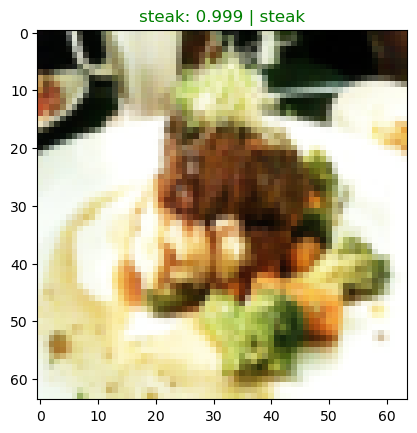

In [467]:
import random 
rand_idx = torch.randint(high=len(test_extended_data), size=(1,)).item()

sample = test_extended_data[rand_idx][0]
model_2.eval()
with torch.inference_mode():
    logits = model_2(sample.unsqueeze(dim=0).to(device))
    pred = torch.softmax(logits, dim=1).argmax(dim=1)

plt.imshow(sample.permute(1, 2, 0))
title = f"{class_names[pred]}: {torch.softmax(logits, dim=1)[0][pred].item():.3f} | {class_names[test_extended_data[rand_idx][1]]}"
if class_names[pred] == class_names[test_extended_data[rand_idx][1]]:
    plt.title(title, c="g")
else:
    plt.title(title, c="r")

In [90]:
model_1_adam_result

{'train_loss': [tensor(1.1033, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(1.0163, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.9539, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.9473, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.9175, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.9054, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.8887, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.8877, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.8959, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.8604, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.8309, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.8090, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.8182, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.8148, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.7903, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.7836, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.7601, device='cuda:0', grad_fn=

Text(0.5, 0, 'epochs')

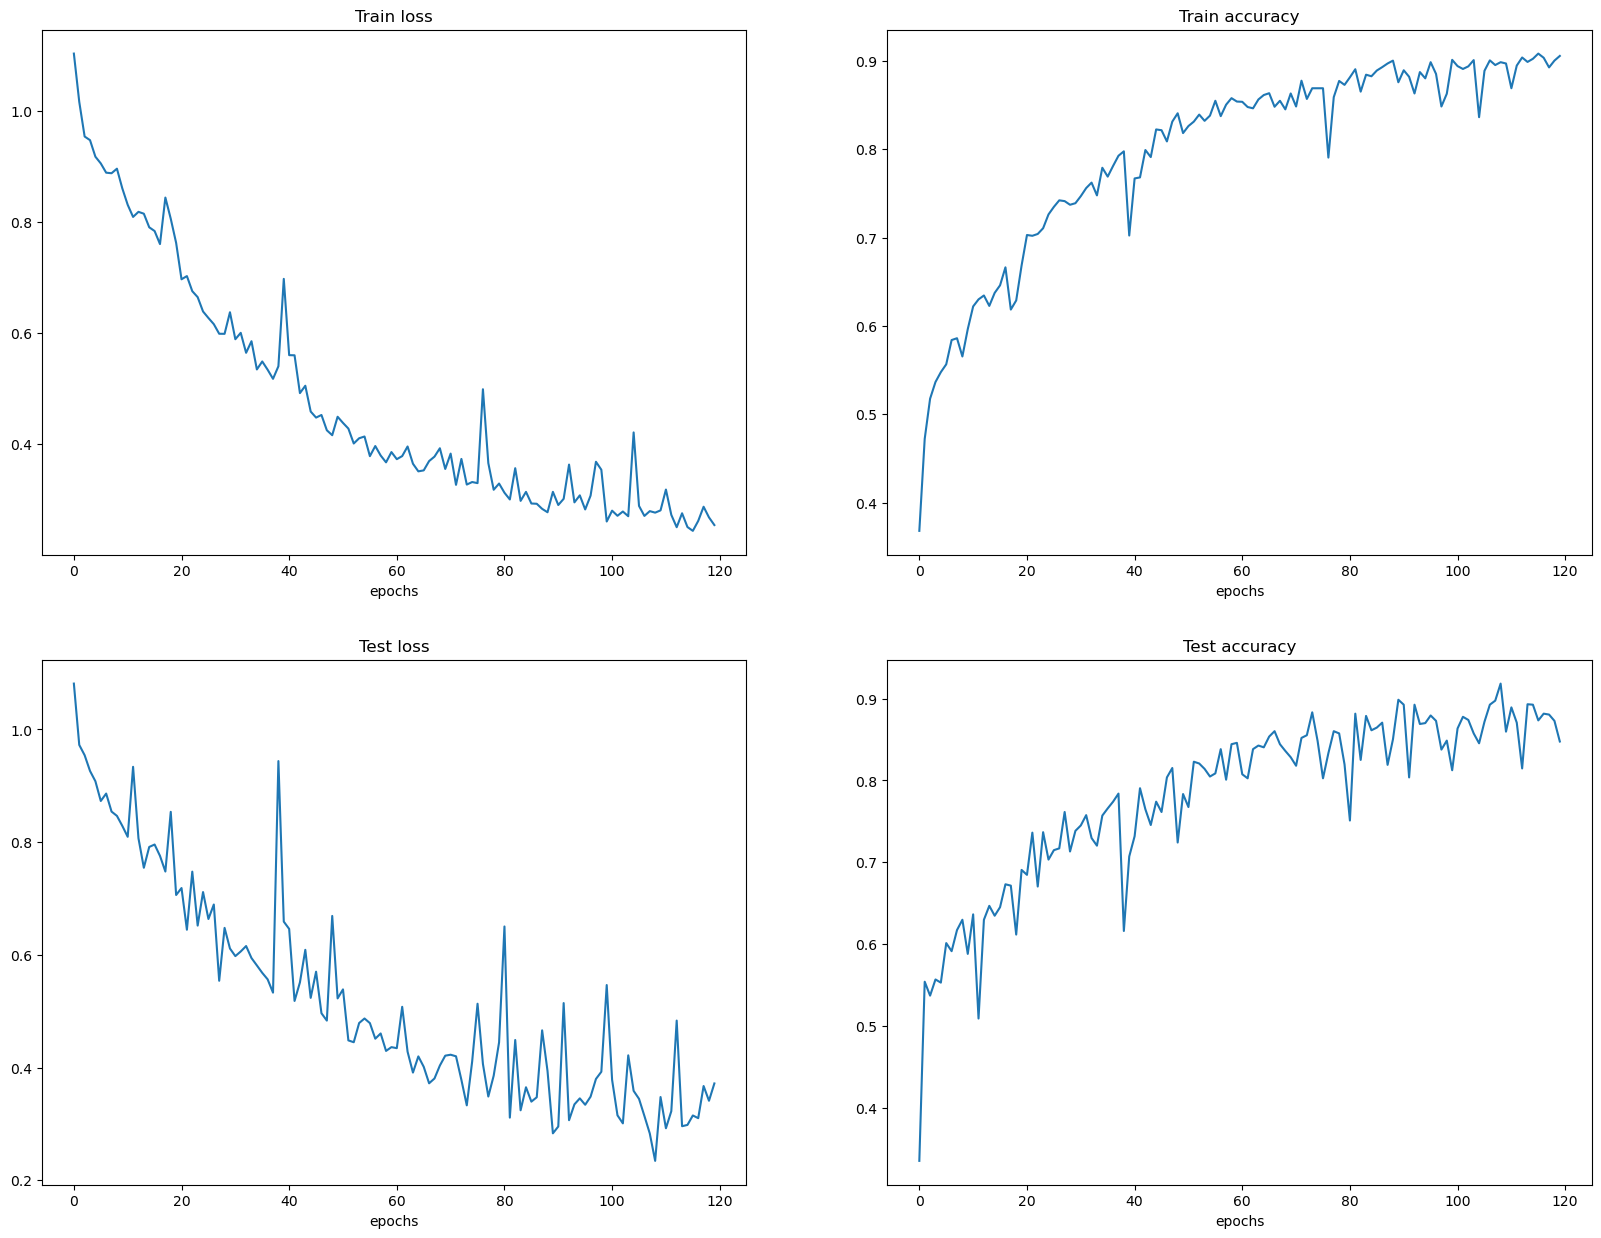

In [112]:
epochs = range(len(model_1_adam_result['train_loss']))
loss_values = [x.detach().cpu() for x in model_1_adam_result['train_loss']]
test_loss_values = [x.detach().cpu() for x in model_1_adam_result['test_loss']]

plt.figure(figsize=(20, 15))

plt.subplot(2, 2, 1)
plt.plot(epochs, loss_values)
plt.title("Train loss")
plt.xlabel("epochs")

plt.subplot(2, 2, 2)
plt.plot(epochs, model_1_adam_result['train_acc'])
plt.title("Train accuracy")
plt.xlabel("epochs")

plt.subplot(2, 2, 3)
plt.plot(epochs, test_loss_values)
plt.title("Test loss")
plt.xlabel("epochs")

plt.subplot(2, 2, 4)
plt.plot(epochs, model_1_adam_result['test_acc'])
plt.title("Test accuracy")
plt.xlabel("epochs")

In [412]:
preds = []

model_2.eval()
with torch.inference_mode():
    for X, _ in test_extended_data:
        logits = model_2(X.unsqueeze(dim=0).to(device))
        pred = torch.softmax(logits, dim=1).argmax(dim=1)
        preds.append(pred)

In [413]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

conftmat = ConfusionMatrix(task="multiclass", num_classes=len(class_names)).to(device)
conftmat_values = conftmat(torch.cat(preds), torch.tensor(test_extended_data.targets).to(device))

(<Figure size 1000x700 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

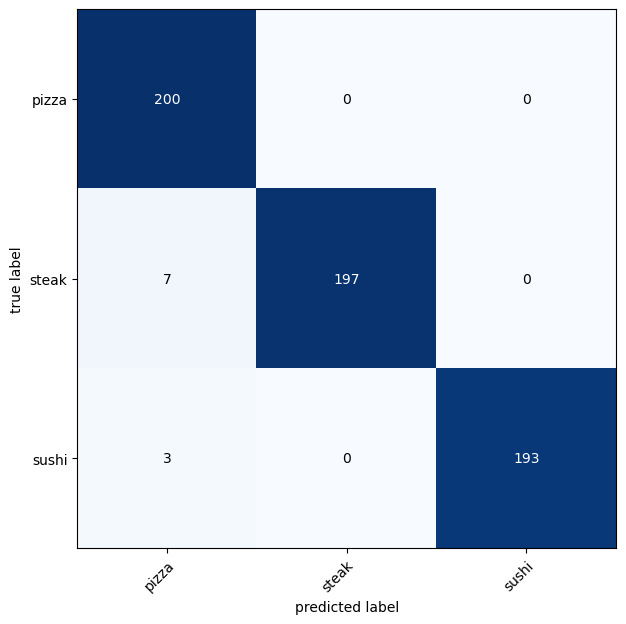

In [414]:
plot_confusion_matrix(conf_mat=conftmat_values.cpu().numpy(), class_names=test_extended_data.classes, figsize=(10, 7))

# PERFECT!!

In [320]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

In [322]:
import torchvision

custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)

In [325]:
# Divide the image pixel values by 255 to get them between [0, 1]
custom_image = custom_image / 255. 

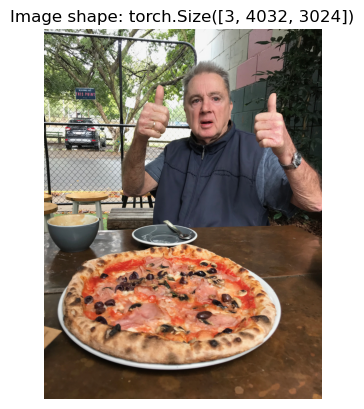

In [326]:
plt.imshow(custom_image.permute(1, 2, 0)) # need to permute image dimensions from CHW -> HWC otherwise matplotlib will error
plt.title(f"Image shape: {custom_image.shape}")
plt.axis(False);

In [327]:
# Create transform pipleine to resize image
custom_image_transform = transforms.Compose([
    transforms.Resize((64, 64)),
])

# Transform target image
custom_image_transformed = custom_image_transform(custom_image)

Text(0.5, 1.0, 'pred: pizza | prob: 0.923')

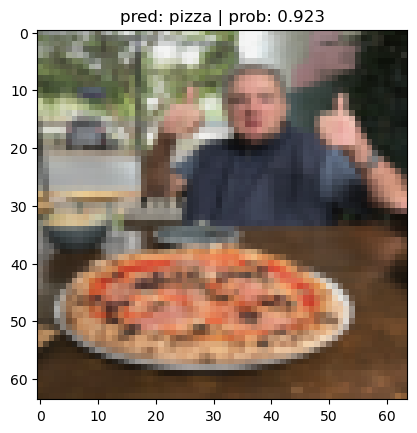

In [424]:
transformed_image = custom_image_transform(custom_image)

logits = model_2(transformed_image.unsqueeze(dim=0).to(device))
pred = torch.softmax(logits, dim=1).argmax(dim=1)

plt.imshow(transformed_image.permute(1, 2, 0))
plt.title(f"pred: {class_names[pred]} | prob: {torch.softmax(logits, dim=1)[0][pred].item():.3f}")